# K Nearest Neighbors/ Approximate Nearest Neighbors, or how to build a vector database

There's lots of hype around vector databases - it looks like there's nothing special about them though. They just seem to be K nearest neighbors machines. Am I missing something? I'm going to try and implement some algorithms from scratch, and build up to HSNW, the apparent state-of-the-art in efficient ANN algorithms for vector databases

For an implementation of HNSW we first need to import the data AND an encoder.
Luckily AutoEncoder.ipynb has trained an encoder using an autoencoder.

In [519]:
# Load FashionMNIST Dataset
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import numpy as np
import importlib
# Reload custom modules in case of refresh
import custom_models
importlib.reload(custom_models)
from custom_models import AutoEncoder, Linspace
from heapq import heapify, heappush, heappop, nsmallest, merge, heappushpop
from random import randrange
from time import time

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

In [199]:

auto_enc_path = "autoencoder.model"

autoenc = torch.load(auto_enc_path)
autoenc.eval()
print(autoenc)

AutoEncoder(
  (Encoder): Linspace(
    (full_model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=784, out_features=556, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=556, out_features=328, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=328, out_features=100, bias=True)
        (1): ReLU()
      )
    )
  )
  (Decoder): Linspace(
    (full_model): Sequential(
      (0): Sequential(
        (0): Linear(in_features=100, out_features=328, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=328, out_features=556, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=556, out_features=784, bias=True)
        (1): ReLU()
      )
    )
  )
  (full_model): Sequential(
    (0): Linspace(
      (full_model): Sequential(
        (0): Sequential(
          (0): Linear(in_features=784, out_features=556

In [432]:
# Extract the Encoder from AutoEncoder
encoder = autoenc.Encoder
decoder = autoenc.Decoder

in_img, in_label = training_data[50301]
flat = in_img.reshape(-1, 28 * 28)
mid = encoder(flat)
pred = decoder(mid) #autoenc(flat)
out_img = pred.reshape(-1, 28, 28)


# Reshape Encoded image to display in grid fmt
mid_img = mid.reshape(-1, 10, 10)
print(mid)

tensor([[0.0000, 0.0000, 1.2543, 0.0000, 0.0000, 0.3116, 0.0000, 0.3030, 0.7631,
         0.8196, 0.0000, 1.7609, 0.0000, 0.2291, 0.0000, 0.0000, 0.0000, 1.0881,
         2.2962, 0.3158, 0.0000, 0.5451, 0.0000, 0.5175, 0.6415, 0.0000, 1.8303,
         0.7220, 0.0000, 0.0000, 2.0184, 0.5886, 0.5796, 0.0000, 0.7984, 1.3519,
         0.6037, 0.0000, 0.1794, 0.0000, 0.0000, 0.1343, 1.1280, 0.4201, 0.0000,
         0.0000, 0.5975, 0.4980, 1.4624, 0.6495, 0.0959, 0.0000, 0.3794, 0.0000,
         0.0000, 0.4647, 0.7303, 0.7141, 0.7748, 0.8357, 0.0000, 0.1220, 0.0000,
         0.0000, 0.2866, 0.0000, 1.8208, 0.0000, 0.2873, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.9418, 0.0000, 0.0000, 0.0000, 0.0000, 0.3556, 0.5633,
         0.0000, 0.0000, 0.3923, 0.0000, 0.0000, 0.9143, 0.0000, 0.1469, 0.0000,
         1.4023, 0.8872, 0.7862, 1.7954, 0.0000, 0.0000, 0.0000, 0.4692, 0.0000,
         0.0607]], grad_fn=<ReluBackward0>)


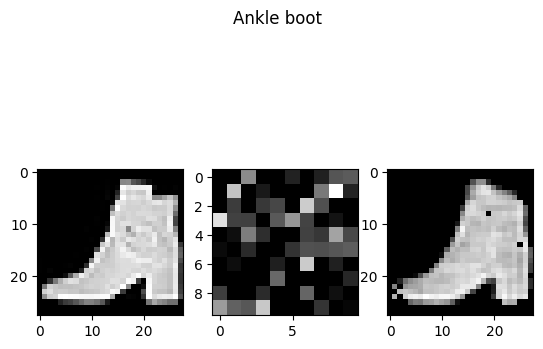

In [433]:
f, ax = plt.subplots(1,3)
# display input img
ax[0].imshow(in_img.squeeze(), cmap='gray')
# display output img
ax[2].imshow(out_img.detach().squeeze(), cmap='gray')
# display mid img
ax[1].imshow(mid_img.detach().squeeze(), cmap='gray')
label_idx = np.argmax(in_label).detach().numpy()
f.suptitle(class_names[label_idx])
plt.show()

Let's try building some KNN data structures/ Vector databases in which we can throw in encoded images

## Navigable Small Worlds

Precursor to HNSW - I initially tried to go straight to HNSW, but it occurred to me that it's somewhat important to make sure I have some fundamentals correct and working, like how to make sure greedy search works, benchmarking and evaluating different ANN algorithms, and testing for correctness.

The key idea here is that greedy searches work? This is actually not true, but it's quite useful when we get to HNSW.

Here's how it works though.

$$
    \textrm{Let } NSW(m, \theta, sim: \mathbb{R}^N \rightarrow \mathbb{R}) = (V, E) \\
    \textrm{Where } V \subset  \mathbb{R}^N \\
    \textrm{and } E \subset V \times V
$$

So a Navigable small world is just a graph of vectors given a similarity function and hyperparameters $m$ and $\theta$, which will determine the degree of the nodes in the graph, and how many greedy searches from random starting points we will perform before returning our final answer. So what's the greedy search? it's extremely simple, but we vary it for the purposes of K nearest neighbors, because we need to make sure that, after $\theta$ searches, we return $k$ candidate vectors with the best similarity values (highest for cosine similarity, lowest for most others). We'll do lookup before add.

```
def greedy(v):
    # Assume that lower similarity is better
    curr := random member of V
    candidate = curr
    while candidate is not None:
        baseline = sim(curr, v)
        candidate = None
        for next s.t (curr,next) is in E:
            dist = sim(v, next)
            if dist < baseline:
                candidate = next
                baseline = dist
        if candidate is not None:
            curr = candidate
    # when we exit this loop, candidate is None, 
    # but curr has no neighbors that beat its baseline 
    # distance from v
    return curr, baseline
```

This algorithm is elegant not only because it's iterative and doesn't require frontier lists and other nonsense, but it also doesn't require a "visited" set to keep track of what we've seen before, because we're only ever going to strictly decrease in distance because our candidate vector and v. But this only returns one result. We are in fact looking for K nearest neighbors. let's modify this by keeping track of a *max* heap of size $k$. Every node we see will simply cause us to peek at the furthest candidate seen so far, and if our current node beats it, we can pop it off and push our new node on.

While we're at it, if we perform $theta$ searches before returning the result list, we have effectively completed the lookup function of $NSW$

```
def lookup(NSW, q, k):
    pre_result := k random members of NSW.V
    maxheap_tokens = [(NSW.sim(q, r), r) for r in pre_result]
    result := maxheap(maxheap_tokens) 
    # built a max-heap of k random nodes in the graph, 
    # along with their distances to query vector q
    # (In Python we'll use -sim(q,v))

    for _ in range(NSW.theta): # loop theta times
        curr := random member of NSW.V
        candidate = curr
        while candidate is not None:
            baseline = sim(curr, q)
            candidate = None
            for next s.t (curr,next) is in NSW.E:
                dist = NSW.sim(q, next)
                if dist < baseline:
                    candidate = next
                    baseline = dist
                # create heap_token for next candidate
                heap_token = (dist, next)
                if heap_token < result.peak_max()
                result.pop_max()
                result.push(heap_token)
            if candidate is not None:
                curr = candidate
    
    # After theta greedy searches, we don't actually care where we terminated.
    # As long as we have maintained a max heap throughout the searches and made
    # sure that each node we saw was checked against it to ensure we keep
    # the k smallest distances, we are guaranteed to have the k closest
    # vectors to v that we haev seen so far.
    return result # you can decide how to format the distances
```

Now that we have lookup, we need to define add. We can do this by using lookup! And now we can look into $m$. $m$ is useful, and in practice needs tuning. However, the basic idea is quite simple.

```
def add(NSW, v):
    if |NSW.V| < NSW.m:
        w := random member of NSW.V
        NSW.V.add(v)
        NSW.E.add(v,w)
    else:
        # connect v to its m nearest neighbors!
        mnn := lookup(NSW, v, NSW.m)
        for w in mnn:
            NSW.E.add(v,w)
```

In [617]:
# Attempt 1: Navigable small world.
class NSW():

    def randrange_exclude(self, end, excl):
        val = randrange(end - 1)
        if val >= excl:
            val += 1
        return val


    # ACTUAL similarity function is always "higher is better"
    def sim(self, x: torch.Tensor, y: torch.Tensor):
        return self.sim_sign * self._sim(x,y)
    
    # Greedy search will behave like a non nearest neighbor greedy search
    # given a result heap of size 1.
    def greedy_search(self, vec: torch.Tensor, result: list[tuple]) -> list[tuple]:
        # print('entered greedy search')
        # randomly sample from graph size
        curr = randrange(len(self.data))
        # initialize candidate to curr
        candidate = curr
        # print(candidate, curr)
        while candidate is not None:
            # baseline distance from current vector must be beaten to continue the search
            baseline = self.sim(vec, self.data[curr])
            candidate = None
            for nxt in self.graph[curr]:
                # get distance from query and next vector
                sim = self.sim(vec, self.data[nxt])
                # higher similarity is better
                if sim > baseline:
                    candidate = nxt
                    baseline = sim
                # compare nxt to the least similar vector while it's being evaluated.
                lowest_similarity = result[0][0] # result stores (dist, idx) in a min heap
                if sim > lowest_similarity and (sim, nxt) not in result:
                    heappushpop(result, (sim, nxt))
            if candidate is not None:
                curr = candidate
        return result
        

    def _conn(self, ida, idb): # idx of two graph members.
        # make sure graph is accessible.
        assert ida < len(self.data), f"index of conn is out of range ({ida} >= {len(self.data)})"
        assert idb < len(self.data), f"index of conn is out of range ({idb} >= {len(self.data)})"
        # no self connections!
        assert ida != idb, "no self connections!"
        # add to both nodes' adj lists
        self.graph[ida].add(idb)
        self.graph[idb].add(ida)

    def _disconnect(self, ida, idb): # idx of two graph members.
        # returns false if disconnect was not possible i.e. too few neighbors
        # make sure graph is accessible.
        assert ida < len(self.data), f"index of conn is out of range ({ida} >= {len(self.data)})"
        assert idb < len(self.data), f"index of conn is out of range ({idb} >= {len(self.data)})"
        # treat as a noop if either node is the other's only connection.
        if len(self.graph[ida]) < 2 or len(self.graph[idb]) < 2:
            return False
        # disallow removes if nodes are not connected already.
        assert idb in self.graph[ida]
        self.graph[ida].remove(idb)
        assert ida in self.graph[idb]
        self.graph[idb].remove(ida)
        # remove from both nodes' adj lists
        return True

    def __init__(
            self,
            M = 100, # refactor limit
            m = 5,   # starting connection number
            theta = 3,
            sim = F.cosine_similarity, 
            sim_sign = 1,
            root = None):
        # sim_sign denotes whether distance function is better lower or higher 
        self.sim_sign = sim_sign # for cosine sim higher is better
        # Use cosine similarity by default
        self._sim = sim
        # Dim must always be agreed upon (only initialized on first vector)
        self.dim = None
        # Master dataset
        self.data = []
        # Graph will define graph search
        self.graph = []
        # Let M be the "refactor"
        self.M = M
        # Let m be the minimum number of allowed connections - force refactor when we hit this limit.
        self.m = m
        # Let theta be the number of times we perform a random search before returning KNN
        self.theta = theta
        assert theta >= 0, "Please enter a valid value of theta (int >= 0)"
        # keep track of num refactors
        self.num_refactors = 0
        # If a root vector was specified, then we can start off by initializing root and dim
        if root:
            self.insert(root)
        pass

    def insert(self, vec):

        if self.dim:
            # Make sure dimensions agree
            assert self.dim == vec.shape, f"Dimensions of vector must match data structure: expected {self.dim}, got {vec.shape}"
        else:
            self.dim = vec.shape

        # push into graph
        idx = len(self.data) # this node's idx will be idx.
        self.data.append(vec)
        self.graph.append(set())

        # If the dataset is less than m (number of connections to be made), connect to random node
        if idx == 0:
            # no connections can be made
            return
        elif idx < self.m:
            w = randrange(idx) # random node other than idx
            self._conn(w, idx)
        else:
            # connect the m nearest neighbors of the vector, making sure that we only keep the best self.M nodes.
            knn = self.lookup(vec, k=self.m, id=True)
            for node in knn:
                if node != idx:
                    self._conn(node, idx)
                    if len(self.graph[node]) > self.M:
                        # force refactor if the degree of any node has become too large
                        self.refactor(node)

        
        # sanity check!
        assert len(self.data) == len(self.graph), f"data len != graph len ({len(self.data)}, {len(self.graph)})"
        self.sanity_check()
        pass

    def refactor(self, idx):
        self.num_refactors += 1
        # copy neighbor list as this will be modified during the loop.
        neighbor_list = [n for n in self.graph[idx]]
        # refactor adjacency list of node idx.
        for neighbor in neighbor_list:
            # disconnect neighbor from parent node
            disconnected = self._disconnect(idx, neighbor)
            if disconnected:
                # reconnect to a random node instead
                self._conn(self.randrange_exclude(len(self.data), neighbor), neighbor)
        # By the end of this process the high degree node now has
        # a degree of 1.


    def lookup(self, vec, k = 3, dist=False, id=False):
        pre_result = [randrange(len(self.data)) for _ in range(k)] # sample k indices from dataset
        result = [(self.sim(vec, self.data[r]), r) for r in pre_result]
        heapify(result)
        # built a min-heap of k random nodes in the graph, 
        # along with their similarity to query vector q

        for _ in range(self.theta):
            result = self.greedy_search(vec, result)


        sim_list = [d[0] for d in result]
        idx_list = [d[1] for d in result]
        if id:
            data_list = idx_list
        else:
            data_list = [self.data[i] for i in idx_list]
        if dist:
            return data_list, sim_list
        else:
            return data_list
    
    def sanity_check(self):
        # Make sure the graph has no over or under-connected nodes!
        for i,g in enumerate(self.graph):
            assert len(g) > 0, f"graph element {i} has no neigbours after {len(self.data)} inserts!"
        return


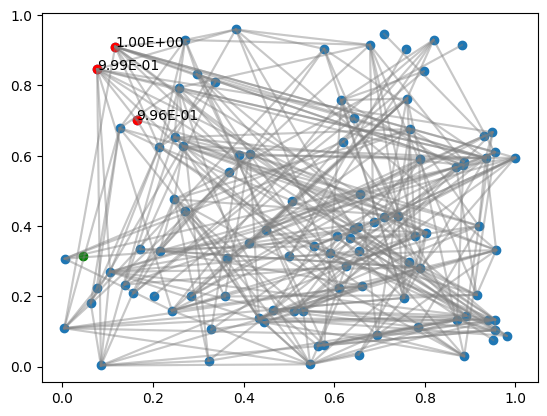

In [622]:
# Test some basic functionality with 2D vectors 
torch.manual_seed(42)
TEST_N = 100
tv = []
for i in range(TEST_N):
    tv.append(torch.rand(2, dtype=torch.float32))
test_vectors = [t.reshape(1, -1) for t in tv]
euclidean = lambda t1, t2 : (t1 - t2).pow(2).sum().sqrt()
test_nsw = NSW(
    sim = F.cosine_similarity,
    sim_sign=1.0
)
for t in test_vectors:
    test_nsw.insert(t)

# plot points in 2D space
xs, ys = [t[0] for t in tv], [t[1] for t in tv]
plt.scatter(xs, ys)

# plot edges in 2d space
for begin in range(len(test_vectors)):
    for end in test_nsw.graph[begin]:
        # plot a line showing the edge
        xs = [tv[begin][0], tv[end][0]]
        ys = [tv[begin][1], tv[end][1]]
        plt.plot(xs, ys, color='gray',  alpha = 0.25)

# generate random query vector in green
query = torch.rand(2, dtype=torch.float32).reshape(1, -1)
plt.scatter(query[0,0], query[0,1], color='green')

# lookup query and label candidates red
cands, dists = test_nsw.lookup(query, dist=True)
candx = [c.detach().numpy().squeeze()[0] for c in cands]
candy = [c.detach().numpy().squeeze()[1] for c in cands]
plt.scatter(candx, candy, color='red')

# label distances
dists = [d.detach().numpy().squeeze() for d in dists]
for cx,cy,d in zip(candx, candy, dists):
    plt.text(cx,cy, f'{d:.2E}')

plt.show()
# print(test_nsw.num_refactors)

In [538]:

# Benchark NSW against size of dataset.
def fill_db(db, num_items):
    def gen_random_query():
        random_query = torch.tensor( # convert to tensor
        np.maximum(0, # apply relu
            np.random.uniform( # uniform from -1 to 1
                low=-1.0,
                high=1.0,
                size=(1,100))), dtype=torch.float32) # encoding size
        return random_query

    insert_times = []
    db_sizes, query_times = [], []
    # shuffle training data.
    for i in (t := trange(num_items)):
        query_img, query_label = training_data[i]
        query_flat = query_img.reshape(-1, 28 * 28)
        query_enc = encoder(query_flat)
        assert query_enc.dtype == torch.float32, f'Got invalid datatype {query_enc.dtype}'
        # time inserts as size increases
        start_time = time()
        db.insert(query_enc)
        end_time = time()
        insert_time = end_time - start_time
        insert_times.append(insert_time)
        # Monitor query time every 100 steps
        if i % 100 == 0:
            start_time = time()
            for _ in range(100):
                r = gen_random_query()
                assert r.dtype == torch.float32, f'Got invalid datatype {r.dtype}'
                _ = db.lookup(r, k = 3)
            end_time = time()
            query_time = end_time - start_time
            query_times.append(query_time)
            db_sizes.append(i)
        t.set_description(f'Curr query time {query_time:.2E} Avg. insert time {insert_time / (i+1)}')
    return insert_times, query_times, db_sizes

In [392]:
def plot_benchmark(inserts, queries, sizes):
    f, ax = plt.subplots(1,2) 
    # insert times
    ax[0].plot(inserts)
    ax[0].set_title('Insert times')
    ax[0].set_xlabel('DB size')
    # query times
    ax[1].plot(sizes, queries)
    ax[1].set_title('Query times (per 100 queries)')
    ax[1].set_xlabel('DB size')

Curr query time 2.31E-01 Avg. insert time 2.0091533660888672e-07: 100%|██████████| 10000/10000 [01:06<00:00, 150.15it/s]


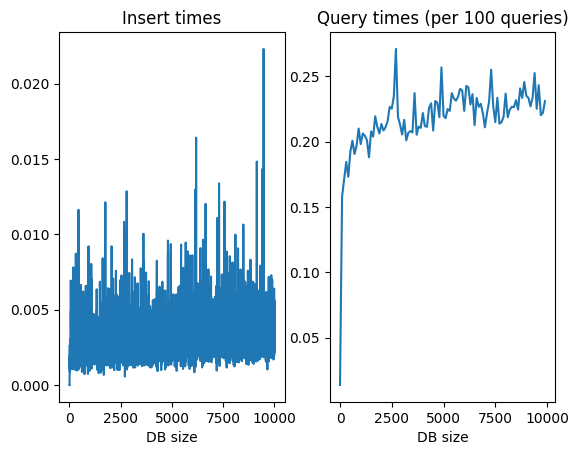

In [623]:
# initialize NSW with random values.
size = len(training_data)
euclidean = lambda t1, t2 : (t1 - t2).pow(2).sum().sqrt()
nsw = NSW(sim=F.cosine_similarity, sim_sign=1)
insert_times, query_times, db_sizes = fill_db(nsw, 10000)
plot_benchmark(insert_times, query_times, db_sizes)

9.8076


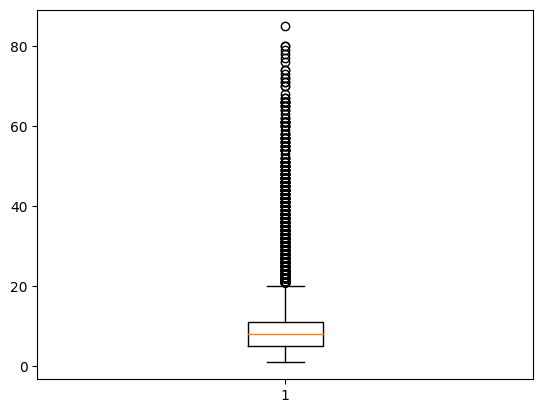

In [620]:
# This is a boxplot of the degrees of nodes in the nsw graph. 
# This was so incredibly important in figuring out what was going on with the long insert/ query times
degrees = [len(g) for g in nsw.graph]
plt.boxplot(degrees)
print(np.mean(degrees))

[array(0.92933285, dtype=float32), array(0.9433516, dtype=float32), array(0.93469507, dtype=float32)]


Text(0.5, 1.0, 'neighbor 3 (dist=9.35E-01)')

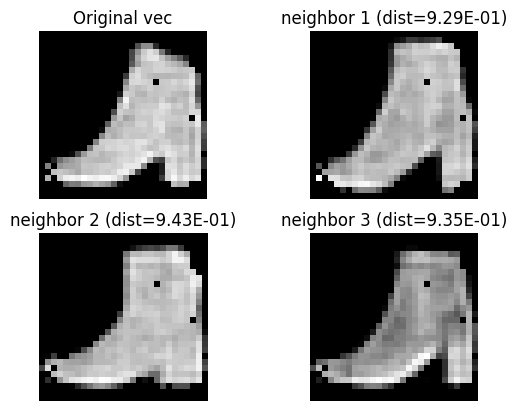

In [627]:
def plot_encoded(axis, vec, decoder):
    out = decoder(vec)
    out_img = out.reshape(-1, 28, 28)
    out_img = out_img.detach().squeeze()
    axis.axis('off')
    axis.imshow(out_img, cmap='gray')
    pass
neighbors, dist = nsw.lookup(mid, dist=True)
dist = [d.detach().numpy().squeeze() for d in dist]
print(dist)
f, ax = plt.subplots(2,2)
# OG
plot_encoded(ax[0][0], mid, decoder)
ax[0][0].set_title('Original vec')
# neighbors
plot_encoded(ax[0][1], neighbors[0], decoder)
ax[0][1].set_title(f'neighbor 1 (dist={dist[0]:.2E})')
plot_encoded(ax[1][0], neighbors[1], decoder)
ax[1][0].set_title(f'neighbor 2 (dist={dist[1]:.2E})')
plot_encoded(ax[1][1], neighbors[2], decoder)
ax[1][1].set_title(f'neighbor 3 (dist={dist[2]:.2E})')


## Locality Sensitive Hashing
Locality sensitive hashing uses geometry to probabilistically cluster vectors into buckets in which all vectors are likely to be close to
The idea is that, when you project a vector onto the normal of a plane, you find out if it's above or below the plane by taking the sign of the value
$$ \textrm{For plane $P$ defined by normal $n$} \\ 
proj(vec,P) = \left\lbrace
    \begin{array}{c l} 
    1 & \textrm{if }proj(vec, n) > 0 \\
    0 & \textrm{otherwise}
    \end{array}
\right.$$

You can use this scheme to "hash" a vector, and build a hash table, where each bucket represents a cluster of vectors that are all above or below the same planes as defined by the set of planes that build the hash!

$$ \textrm{for planes } P_1..P_n \\
hash(vec) = b_1..b_n \\
\textrm{where } b_i = proj(vec, P_i)
$$

How do you make sure you chose the right planes to split the $N$-dimensional space appropriately? You don't have to, if you hash multiple times.
Define multiple hash sets, and add each vector to the bucket that each hash set generates. During lookup, perform an exhaustive lookup of the buckets to which each plane set hashes a given vector

```
def add(vec):
    for planeSet S in planeSets:
        hash := hash(vec, planeSet)
        hashtable[planeset].add(vec)

def lookup(vec):
    candidates = []
    for planeSet S in planeSets:
        hash            := hash(vec, planeSet)
        bucket          := hashtable[planeset]
        new_candidates  := exhaustive_search(vec, bucket)
        merge(candidates, new_candidates)
    return k-nearest(candidates)
```

In [628]:
class LSHTable():

    def hash(self, ps, vec):
        # given a planeset index and vector, generate and return the hash.
        planes = self.planesets[ps]
        proj = vec @ planes
        signs = (proj > 0).detach().numpy().squeeze()
        h = 0
        for i in range(signs.shape[0]):
            h += (2 ** i) * int(signs[i])
        return h

    def exhaustive_search(self, candidates, vec, k):
        # store distance and indices (multiplied by sign of dist metrics for each candidate)
        dist_idx = [(self.sim(self.data[i], vec) * self.sim_sign, i) for i in candidates]
        # heapify to get n smallest
        heapify(dist_idx)
        filter_by_n = nsmallest(k, dist_idx)
        return filter_by_n

    def __init__(self, 
                 P = 8, 
                 H = 3, 
                 dim=(1, 100), 
                 sim=F.cosine_similarity, sim_sign=-1):
        # dimensions of vector must be known before initialization
        self.dim = dim[1]
        # let P = the number of planes that will be applied to each vector
        self.P = P
        # Let H = number of hashes generated
        self.H = H
        # Create H sets of planes to generate hashes.
        self.planesets = [torch.rand(self.dim, self.P, dtype=torch.float32) * 2 - 1 for _ in range(self.H)]
        # use data list, hash list in order to rehash if necessary.
        self.data, self.hashes = [], []
        # Initialize empty dictionary
        self.vec_dict = dict()
        # save similarity function
        self.sim = sim
        # Remember whether higher sim means closer or lower
        self.sim_sign = sim_sign
        pass

    def insert(self, vec):
        # new index is the length of data list before insertion
        new_idx = len(self.data)
        self.data.append(vec)
        self.hashes.append([])
        for p in range(self.H):
            h = self.hash(p, vec)
            # print(f'Generated hash {hex(h)}')
            self.hashes[new_idx].append(h)
        # Add index to dictionary based on all hashes.
        for h in self.hashes[new_idx]:
            if h not in self.vec_dict:
                self.vec_dict[h] = []
            self.vec_dict[h].append(new_idx)        
        pass

    def lookup(self, vec, k=3, dist=False):
        # Compute hashes 
        hashes = []
        for p in range(self.H):
            h = self.hash(p, vec)
            # print(f'Generated hash {hex(h)}')
            hashes.append(h)
        candidates = []
        for h in hashes:
            candidates += self.vec_dict[h] if h in self.vec_dict else []
        if not candidates:
            # print('No hits! Exhaustive search.')
            res = self.exhaustive_search(list(range(len(self.data))), vec, k)
        else:
            res = self.exhaustive_search(candidates, vec, k)
        if dist:
            vecs = [self.data[i[1]] for i in res]
            dist = [i[0] for i in res]
            return [(i[0], self.data[i[1]]) for i in res]
        else:
            return 


In [629]:
class LSHTable():

    def hash(self, ps, vec):
        # given a planeset index and vector, generate and return the hash.
        planes = self.planesets[ps]
        proj = vec @ planes
        signs = (proj > 0).detach().numpy().squeeze()
        h = 0
        for i in range(signs.shape[0]):
            h += (2 ** i) * int(signs[i])
        return h

    def exhaustive_search(self, candidates, vec, k):
        # store distance and indices (multiplied by sign of dist metrics for each candidate)
        dist_idx = [(self.sim(self.data[i], vec) * self.sim_sign, i) for i in candidates]
        # heapify to get n smallest
        heapify(dist_idx)
        filter_by_n = nsmallest(k, dist_idx)
        return filter_by_n

    def __init__(self, 
                 P = 8, 
                 H = 3, 
                 dim=(1, 100), 
                 sim=F.cosine_similarity, sim_sign=-1):
        # dimensions of vector must be known before initialization
        self.dim = dim[1]
        # let P = the number of planes that will be applied to each vector
        self.P = P
        # Let H = number of hashes generated
        self.H = H
        # Create H sets of planes to generate hashes.
        self.planesets = [torch.rand(self.dim, self.P, dtype=torch.float32) * 2 - 1 for _ in range(self.H)]
        # use data list, hash list in order to rehash if necessary.
        self.data, self.hashes = [], []
        # Initialize empty dictionary
        self.vec_dict = dict()
        # save similarity function
        self.sim = sim
        # Remember whether higher sim means closer or lower
        self.sim_sign = sim_sign
        pass

    def insert(self, vec):
        # new index is the length of data list before insertion
        new_idx = len(self.data)
        self.data.append(vec)
        self.hashes.append([])
        for p in range(self.H):
            h = self.hash(p, vec)
            # print(f'Generated hash {hex(h)}')
            self.hashes[new_idx].append(h)
        # Add index to dictionary based on all hashes.
        for h in self.hashes[new_idx]:
            if h not in self.vec_dict:
                self.vec_dict[h] = []
            self.vec_dict[h].append(new_idx)        
        pass

    def lookup(self, vec, k=3, dist=False):
        # Compute hashes 
        hashes = []
        for p in range(self.H):
            h = self.hash(p, vec)
            # print(f'Generated hash {hex(h)}')
            hashes.append(h)
        candidates = []
        for h in hashes:
            candidates += self.vec_dict[h] if h in self.vec_dict else []
        if not candidates:
            # print('No hits! Exhaustive search.')
            res = self.exhaustive_search(list(range(len(self.data))), vec, k)
        else:
            res = self.exhaustive_search(candidates, vec, k)
        if dist:
            vecs = [self.data[i[1]] for i in res]
            dist = [i[0] for i in res]
            return vecs, dist
        else:
            return [self.data[i[1]] for i in res]


Curr query time 8.36E-01 Avg. insert time 9.012222290039063e-09: 100%|██████████| 5000/5000 [00:36<00:00, 138.51it/s] 


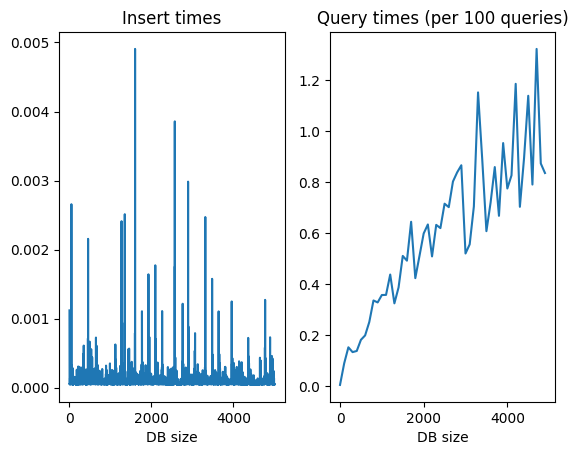

In [630]:
lsh = LSHTable(P = 8)
insert_times, query_times, db_sizes = fill_db(lsh, 5000)
plot_benchmark(insert_times, query_times, db_sizes)

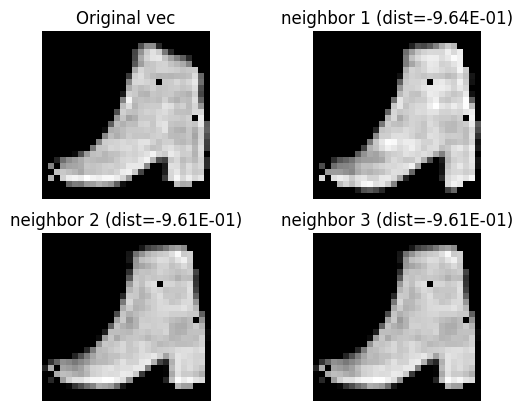

In [631]:
# Try a lookup on the LSH vector DB

neighbors, dist = lsh.lookup(mid, dist=True)
dist = [d.detach().numpy().squeeze() for d in dist]
f, ax = plt.subplots(2,2)
# OG
plot_encoded(ax[0][0], mid, decoder)
ax[0][0].set_title('Original vec')
# neighbors
plot_encoded(ax[0][1], neighbors[0], decoder)
ax[0][1].set_title(f'neighbor 1 (dist={dist[0]:.2E})')
plot_encoded(ax[1][0], neighbors[1], decoder)
ax[1][0].set_title(f'neighbor 2 (dist={dist[1]:.2E})')
plot_encoded(ax[1][1], neighbors[2], decoder)
ax[1][1].set_title(f'neighbor 3 (dist={dist[2]:.2E})')
plt.show()


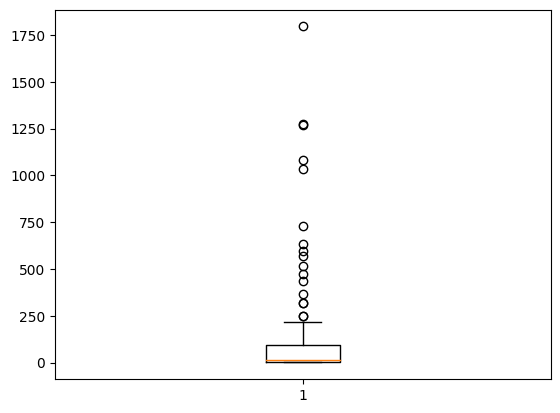

15.0


In [632]:
# box plot of bucket sizes
bucket_sizes = [len(lsh.vec_dict[k]) for k in lsh.vec_dict]
plt.boxplot(bucket_sizes)
plt.show()
print(np.median(bucket_sizes))